※Number of Fukushima is 36.

※Number of Aizu Wakamastu is 47570.

In [ ]:
!pip install beautifulsoup4 pytz

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta
from ctypes import DEFAULT_MODE
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import pytz
import csv
import math

prefecture_code = 36 #Number of Fukushima
city_code = 47570 #Number of Aizu Wakamatsu
place = "Aizu Wakamatsu"

In [2]:
# Get the real time in Japan
japan_tz = 'Asia/Tokyo'
current_time = datetime.now(pytz.timezone(japan_tz))
print("Current time in Japan:", current_time.strftime('%Y-%m-%d %H:%M:%S'))

Current time in Japan: 2024-06-27 11:35:30


Use data from the day before the current date to 10 days before.

※Since the data obtained and executed is based on the current time, the results may vary depending on the day.

### For example:

Runing day: 2024/6/20

Data used in this program:

2024/6/19、2024/6/18、2024/6/17、2024/6/16、2024/6/15、2024/6/14、2024/6/13、2024/6/12、2024/6/11、2024/6/10

In [3]:
# Get the year, month, and day
year = current_time.strftime('%Y')
month = current_time.strftime('%m')
day = []

# Use data from the day before the current date to 10 days before
for i in range(11):
    previous_day = current_time - timedelta(days=i+1)
    day.append(previous_day.strftime('%d'))

print("Dates used in the data:")
for d in day:
  print(f"{year}-{month}-{d}")

Dates used in the data:
2024-06-26
2024-06-25
2024-06-24
2024-06-23
2024-06-22
2024-06-21
2024-06-20
2024-06-19
2024-06-18
2024-06-17
2024-06-16


Based on the current time and the temperature for the past three hours, a linear model is used to predict the temperature for the next hour and compare it with the actual temperature. This process is repeated for 10 days of data.

Temperature data is obtained directly from the Japan Meteorological Agency website by scraping.

In [4]:
base_url = "https://www.data.jma.go.jp/obd/stats/etrn/view/hourly_s1.php?prec_no=%s&block_no=%s&year=%s&month=%s&day=%s&view=p1"

# Convert the data you get into a float type
def str2float(str):
  try:
    return float(str)
  except:
    return 0.0

A = [] # Use when plotting graphs
Predicted = [] # Store all predicted temperatures. Use when plotting graphs
Actual = [] # Store all actual temperatures. Use when plotting graphs
all_data = []
cal_sd = []
error_sum = 0
print(f"Observation area({place})\n")

for d in day:
  # Apply each value to the URL
  r = requests.get(base_url%(prefecture_code, city_code, year, month, d))
  r.encoding = r.apparent_encoding

  # Scraping the site
  soup = BeautifulSoup(r.text)
  # Use findAll to extract all tr ​​tags with class mtx
  rows = soup.findAll('tr',class_='mtx')

  # The first two rows of the table are column information, so they are sliced
  rows = rows[2:]
  daily_data = []
  for row in rows:
    # Extract all td from tr
    data = row.findAll('td')
    # Extracting Data
    rowData = []
    rowData.append(str(year)+"/"+str(month)+"/"+str(d)+"/"+str(data[0].string)+":00")
    rowData.append(str2float(data[4].string)) #tempereture

    # Add data to the next row
    daily_data.append(rowData)
  all_data.append(daily_data)

flat_data = [item for sublist in all_data for item in sublist]

for day_index in range(10):
  for hour in range(24):
    data_index = day_index * 24 + hour
    # At 1:00, linear regression is performed using the temperatures at 24:00, 23:00, and 22:00 of the previous day.
    if data_index==0 or data_index==24 or data_index==48 or data_index==72 or data_index==96  or data_index==120 or data_index==144 or data_index==168 or data_index==192 or data_index==216:
      temperatures = np.array([flat_data[data_index+45][1],flat_data[data_index+46][1],flat_data[data_index+47][1],flat_data[data_index][1]])
      X = np.array([[data_index+45],[data_index+46],[data_index+47],[data_index]])
    # At 2:00, linear regression is performed using the temperatures at 1:00 on the same day, and 24:00 and 23:00 on the previous day
    if data_index==1 or data_index==25 or data_index==49 or data_index==73 or data_index==97  or data_index==121 or data_index==145 or data_index==169 or data_index==193 or data_index==217:
      temperatures = np.array([flat_data[data_index+45][1],flat_data[data_index+46][1],flat_data[data_index-1][1],flat_data[data_index][1]])
      X = np.array([[data_index+45],[data_index+46],[data_index-1],[data_index]])
    # At 3:00, linear regression is performed using the temperatures at 1:00, 2:00 on the same day, and 24:00 on the previous day
    if data_index==2 or data_index==26 or data_index==50 or data_index==74 or data_index==98  or data_index==122 or data_index==146 or data_index==170 or data_index==194 or data_index==218:
      temperatures = np.array([flat_data[data_index+45][1],flat_data[data_index-2][1],flat_data[data_index-1][1],flat_data[data_index][1]])
      X = np.array([[data_index+45],[data_index-2],[data_index-1],[data_index]])
    # If it is after 4:00, perform linear regression using the hourly temperatures up to 3 hours prior
    else:
      temperatures = np.array([flat_data[data_index-3][1],flat_data[data_index-2][1],flat_data[data_index-1][1],flat_data[data_index][1]])
      X = np.array([[data_index-3],[data_index-2],[data_index-1],[data_index]])

    y = temperatures
    # Using Linear Regression
    model = LinearRegression()
    # Training the model
    model.fit(X, y)
    A.append(flat_data[data_index][0])
    # Temperature forecast after one hour using linear regression
    predicted_temp = model.predict(np.array([[data_index+1]]))
    Predicted.append(predicted_temp[0])
    Actual.append(flat_data[data_index][1])
    error = abs(predicted_temp[0] - flat_data[data_index][1]) #Absolute value
    cal_sd.append(error)
    error_sum += error
    print(f"({flat_data[data_index][0]})[Predicted temperature:{predicted_temp[0]:.2f}℃ / Actual temperature:{flat_data[data_index][1]}℃]")
    print(f"Error of temperature: {error:.2f}℃")
    print("=============================================================================")

Observation area(Aizu Wakamatsu)

(2024/06/26/1:00)[Predicted temperature:21.60℃ / Actual temperature:21.8℃]
Error of temperature: 0.20℃
(2024/06/26/2:00)[Predicted temperature:21.65℃ / Actual temperature:21.2℃]
Error of temperature: 0.45℃
(2024/06/26/3:00)[Predicted temperature:21.43℃ / Actual temperature:21.2℃]
Error of temperature: 0.23℃
(2024/06/26/4:00)[Predicted temperature:20.20℃ / Actual temperature:20.5℃]
Error of temperature: 0.30℃
(2024/06/26/5:00)[Predicted temperature:19.15℃ / Actual temperature:19.5℃]
Error of temperature: 0.35℃
(2024/06/26/6:00)[Predicted temperature:19.25℃ / Actual temperature:20.1℃]
Error of temperature: 0.85℃
(2024/06/26/7:00)[Predicted temperature:23.10℃ / Actual temperature:23.3℃]
Error of temperature: 0.20℃
(2024/06/26/8:00)[Predicted temperature:27.90℃ / Actual temperature:26.0℃]
Error of temperature: 1.90℃
(2024/06/26/9:00)[Predicted temperature:29.05℃ / Actual temperature:26.1℃]
Error of temperature: 2.95℃
(2024/06/26/10:00)[Predicted temperatur

In [5]:
# function(example: [1,2,3,4] -> [2,1,4,3])
def sort_elements(arr):
    half_1 = arr[:24][::-1]
    half_2 = arr[24:48][::-1]
    half_3 = arr[48:72][::-1]
    half_4 = arr[72:96][::-1]
    half_5 = arr[96:120][::-1]
    half_6 = arr[120:144][::-1]
    half_7 = arr[144:168][::-1]
    half_8 = arr[168:192][::-1]
    half_9 = arr[192:216][::-1]
    half_10 = arr[216:240][::-1]
    half_11 = arr[240:][::-1]

    new_arr = half_1 + half_2 + half_3 + half_4 + half_5 + half_6 + half_7 + half_8 + half_9 + half_10 + half_11
    return new_arr

# function(example: [1,2,3,4] -> [2,4])
def extract_elements(arr):
    new_arr = []
    index = 0
    while index < len(arr):
        new_arr.append(arr[index])
        index += 24
    return new_arr

#The order of the array is messy, so use the function above to clean up the order so that it is easier to use in graphs.
Predicted_ch = list(reversed(sort_elements(Predicted)))
Actual_ch = list(reversed(sort_elements(Actual)))
A_ch = list(reversed(sort_elements(A)))
#print(Predicted_ch)
#print(Actual_ch)
#print(A_ch)
B = extract_elements(A_ch)
#print(B)

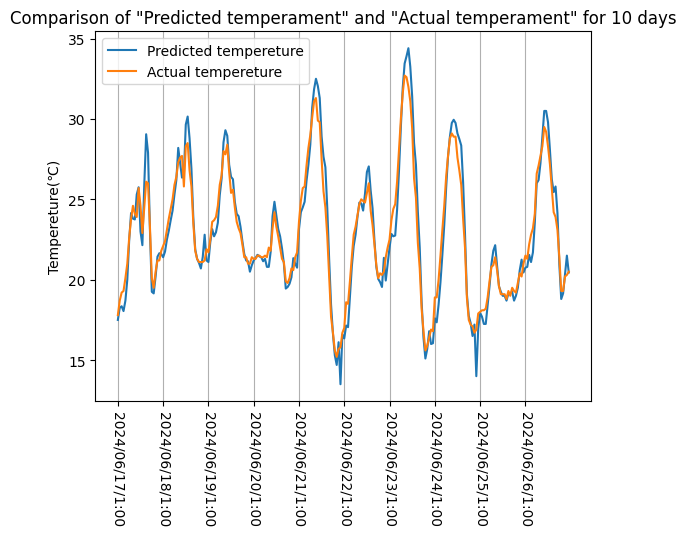

In [6]:
x = list(range(len(A_ch)))
plt.plot(x, list(reversed(Predicted_ch)), label='Predicted tempereture')
plt.plot(x, list(reversed(Actual_ch)), label='Actual tempereture')

# Displaying labels for every hour makes it hard to see, so display only 1:00 for 10 days as labels.
plt.xticks(ticks=[0,24,48,72,96,120,144,168,192,216], labels = B, rotation=-90)

plt.ylabel('Tempereture(℃)')
plt.title('Comparison of "Predicted temperament" and "Actual temperament" for 10 days')
plt.legend()
plt.grid(axis='x')
plt.show()

In [7]:
# Caluculate the average of error and standard deviation

def standard_deviation(data):
    # caluculate the average
    ave = sum(data)/len(data)
    # Calculate the variance
    var = sum((x-ave) ** 2 for x in data)/len(data)
    # Calculate the standard deviation
    standard_deviation = math.sqrt(var)
    return standard_deviation

error_ave = error_sum/len(Predicted)
std_dev = standard_deviation(cal_sd)
print(f"Average of Error: {error_ave:.2f}℃")
print(f"Standard deviation: {std_dev}")

Average of Error: 0.79℃
Standard deviation: 0.6116301008736023


From the graph, the shapes of the predicted and actual temperatures are similar. 